In [8]:
!pip install timm torch torchvision torchaudio

In [9]:
import timm
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [10]:
# weights initialization
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0) # Fill the input Tensor(m.bias.data) with the value val(0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02) # Fill the input Tensor with values drawn from the normal distribution.(mean = 1, std = 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

In [11]:
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return [x,f]
        else:
            x = self.classifier(x)
            return x

In [12]:
class LATransformer(nn.Module):
    def __init__(self, model, lmbd ):
        super(LATransformer, self).__init__()

        self.class_num = 751
        self.part = 14 # We cut the pool5 to sqrt(N) parts
        self.num_blocks = 12
        self.model = model
        self.model.head.requires_grad_ = False
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,768))
        self.dropout = nn.Dropout(p=0.5) # During training, randomly zeroes some of the elements of the input tensor with probability p = 0.5
        self.lmbd = lmbd
        for i in range(self.part):
            name = 'classifier'+str(i)
            setattr(self, name, ClassBlock(768, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))



    def forward(self,x):

        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)

        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)

        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)

        # Average pool
        x = self.avgpool(x[:, 1:])

        # Add global cls token to each local token
        for i in range(self.part):
            out = torch.mul(x[:, i, :], self.lmbd)
            x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)

        # Locally aware network
        part = {}
        predict = {}
        for i in range(self.part):
            part[i] = x[:,i,:]
            name = 'classifier'+str(i)
            c = getattr(self,name)
            predict[i] = c(part[i])
        return predict

In [13]:
class LATransformerTest(nn.Module):
    def __init__(self, model, lmbd ):
        super(LATransformerTest, self).__init__()

        self.class_num = 751
        self.part = 14 # We cut the pool5 to sqrt(N) parts
        self.num_blocks = 12
        self.model = model
        self.model.head.requires_grad_ = False
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,768))
        self.dropout = nn.Dropout(p=0.5)
        self.lmbd = lmbd
#         for i in range(self.part):
#             name = 'classifier'+str(i)
#             setattr(self, name, ClassBlock(768, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))



    def forward(self,x):

        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)

        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)

        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)

        # Average pool
        x = self.avgpool(x[:, 1:])

        # Add global cls token to each local token
#         for i in range(self.part):
#             out = torch.mul(x[:, i, :], self.lmbd)
#             x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)

        return x.cpu()

## Utils

In [14]:
import os
import csv
import torch
from collections import OrderedDict

In [15]:
def update_summary(epoch, train_metrics, eval_metrics, filename, write_header=False):
    rowd = OrderedDict(epoch=epoch)
    rowd.update([('train_' + k, v) for k, v in train_metrics.items()])
    rowd.update([('eval_' + k, v) for k, v in eval_metrics.items()])
    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        if write_header:  # first iteration (epoch == 1 can't be used)
            dw.writeheader()
        dw.writerow(rowd)
        
def save_network(network, epoch_label, name):
    save_filename = 'net_%s.pth'% "best"
    save_path = os.path.join('./model',name,save_filename)
    torch.save(network.cpu().state_dict(), save_path)

    if torch.cuda.is_available():
        network.cuda()
        
def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        #filename = path.split('/')[-1]
        filename = os.path.basename(path)
        label = filename[0:4]
        camera = filename.split('c')[1]
        if label[0:2]=='-1':
            labels.append(-1)
        else:
            labels.append(int(label))
        camera_id.append(int(camera[0]))
    return camera_id, labels

## Metrics

In [16]:
def rank1(label, output):
    if label==output[1][0][0]:
        return True
    return False

def rank5(label, output):
    if label in output[1][0][:5]:
        return True
    return False

def rank10(label, output):
    if label in output[1][0][:10]:
        return True
    return False

def calc_map(label, output):
    count = 0
    score = 0
    good = 0
    for out in output[1][0]:
        count += 1
        if out==label:
            good += 1
            score += (good/count)
    if good==0:
        return 0
    return score/good

# Training

## Import libraries

In [17]:
from __future__ import print_function

import time
import random
import zipfile
from itertools import chain

os.environ['CUDA_VISIBLE_DEVICES']='1'
device = "cuda"

In [18]:
batch_size = 32
# num_epochs = 30
num_epochs = 5
lr = 3e-4
gamma = 0.7
unfreeze_after=2
lr_decay=.8
lmbd = 8

## Load data

In [19]:
transform_train_list = [
    transforms.Resize((224,224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_val_list = [
    transforms.Resize(size=(224,224),interpolation=3), #Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
data_transforms = {
'train': transforms.Compose( transform_train_list ),
'val': transforms.Compose(transform_val_list),
}

In [20]:
image_datasets = {}
data_dir = "/kaggle/input/data-marketpytorch-la-transformer/Market-Pytorch/Market"

image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])
train_loader = DataLoader(dataset = image_datasets['train'], batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = image_datasets['val'], batch_size=batch_size, shuffle=True)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=opt.batchsize,
#                                              shuffle=True, num_workers=8, pin_memory=True) # 8 workers may work faster
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(len(class_names))

751


## Load Model

In [21]:
# Load pre-trained ViT
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=751)
vit_base= vit_base.to(device)
vit_base.eval()

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [22]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def validate(model, loader, loss_fn):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()

    model.eval()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()
    last_idx = len(loader) - 1

    running_loss = 0.0
    running_corrects = 0.0

    with torch.no_grad():
        for input, target in tqdm(loader):

            input, target = input.to(device), target.to(device)

            output = model(input)

            score = 0.0
            sm = nn.Softmax(dim=1)
            for k, v in output.items():
                score += sm(output[k])
            _, preds = torch.max(score.data, 1)

            loss = 0.0
            for k,v in output.items():
                loss += loss_fn(output[k], target)


            batch_time_m.update(time.time() - end)
            acc = (preds == target.data).float().mean()
            epoch_loss += loss/len(loader)
            epoch_accuracy += acc / len(loader)

            print(f"Epoch : {epoch+1} - val_loss : {epoch_loss:.4f} - val_acc: {epoch_accuracy:.4f}", end="\r")
    print()
    metrics = OrderedDict([('val_loss', epoch_loss.data.item()), ("val_accuracy", epoch_accuracy.data.item())])


    return metrics

In [24]:
def train_one_epoch(
        epoch, model, loader, optimizer, loss_fn,
        lr_scheduler=None, saver=None, output_dir='',
        loss_scaler=None, model_ema=None, mixup_fn=None):



    print("come to train one epoch")
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    running_loss = 0.0
    running_corrects = 0.0

    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)


        data_time_m.update(time.time() - end)

        optimizer.zero_grad()
        output = model(data)
        score = 0.0
        sm = nn.Softmax(dim=1)
        for k, v in output.items():
            score += sm(output[k])
        _, preds = torch.max(score.data, 1)

        loss = 0.0
        for k,v in output.items():
            loss += loss_fn(output[k], target)
        loss.backward()

        optimizer.step()

        batch_time_m.update(time.time() - end)

#         print(preds, target.data)
        acc = (preds == target.data).float().mean()

#         print(acc)
        epoch_loss += loss/len(loader)
        epoch_accuracy += acc / len(loader)
#         if acc:
#             print(acc, epreds, target.data)
        print(
    f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}"
, end="\r")

    print()

    return OrderedDict([('train_loss', epoch_loss.data.item()), ("train_accuracy", epoch_accuracy.data.item())])

In [25]:
def freeze_all_blocks(model):
    frozen_blocks = 12
    for block in model.model.blocks[:frozen_blocks]:
        for param in block.parameters():
            param.requires_grad=False

In [26]:
def unfreeze_blocks(model, amount= 1):

    for block in model.model.blocks[11-amount:]:
        for param in block.parameters():
            param.requires_grad=True
    return model

## Training

In [27]:
# Create LA Transformer
model = LATransformer(vit_base, lmbd).to(device)
print(model.eval())

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(),weight_decay=5e-4, lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
freeze_all_blocks(model)

LATransformer(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none'

In [28]:
# name = "la_with_lmbd_{}".format(lmbd)
# os.mkdir("model")
# try:
#     os.mkdir("model/" + name)
# except:
#     print("error create folder")

In [29]:
best_acc = 0.0
y_loss = {} # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []
print("training...")
output_dir = ""
best_acc = 0
name = "la_with_lmbd_{}".format(lmbd)
try:
    os.mkdir("model")
except:
    print("error create folder model")
try:
    os.mkdir("model/" + name)
    print("mkdir successfully")
except:
    print("error create folder")
output_dir = "model/" + name
unfrozen_blocks = 0

training...
mkdir successfully


In [ ]:
for epoch in range(num_epochs):

    if epoch%unfreeze_after==0:
        unfrozen_blocks += 1
        model = unfreeze_blocks(model, unfrozen_blocks)
        optimizer.param_groups[0]['lr'] *= lr_decay
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("Unfrozen Blocks: {}, Current lr: {}, Trainable Params: {}".format(unfrozen_blocks,
                                                                             optimizer.param_groups[0]['lr'],
                                                                             trainable_params))

    train_metrics = train_one_epoch(
        epoch, model, train_loader, optimizer, criterion,
        lr_scheduler=None, saver=None)

    eval_metrics = validate(model, valid_loader, criterion)


    # update summary
    update_summary(epoch, train_metrics, eval_metrics, os.path.join(output_dir, 'summary.csv'),
                   write_header=True)

    # deep copy the model
    last_model_wts = model.state_dict()
    if eval_metrics['val_accuracy'] > best_acc:
        best_acc = eval_metrics['val_accuracy']
        save_network(model, epoch,name)
        print("SAVED!")

# Testing

In [30]:
from __future__ import print_function

import time
import random
import zipfile
from itertools import chain

os.environ['CUDA_VISIBLE_DEVICES']='1'
device = "cuda"

In [31]:
batch_size = 8
gamma = 0.7
seed = 42

In [32]:
torch.cuda.is_available()

True

In [33]:
!pip install transformers

In [34]:
# Load ViT
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=751)
vit_base= vit_base.to(device)

# Create La-Transformer
model = LATransformerTest(vit_base, lmbd=8).to(device)


## Model loader

In [35]:
# Load LA-Transformer
# save_path = '/kaggle/input/weight-la-transformer/net_best.pth'
save_path = 'model/la_with_lmbd_8/net_best.pth'

model.load_state_dict(torch.load(save_path), strict=False)
model.eval()

LATransformerTest(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='n

## Data loader

In [36]:
transform_query_list = [
    transforms.Resize((224,224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_gallery_list = [
    transforms.Resize(size=(224,224),interpolation=3), #Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
data_transforms = {
'query': transforms.Compose( transform_query_list ),
'gallery': transforms.Compose(transform_gallery_list),
}

In [37]:
image_datasets = {}
data_dir = "/kaggle/input/data-marketpytorch-la-transformer/Market-Pytorch/Market"

image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)

class_names = image_datasets['query'].classes
print(len(class_names))

750


## Extract features

In [38]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [39]:
def extract_feature(model,dataloaders):

    features =  torch.FloatTensor()
    count = 0
    idx = 0
    for data in tqdm(dataloaders):
        img, label = data
        img, label = img.to(device), label.to(device)

        output = model(img)

        n, c, h, w = img.size()

        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
    return features

In [40]:
# Extract Query Features
query_feature= extract_feature(model, query_loader)

# Extract Gallery Features
gallery_feature = extract_feature(model, gallery_loader)

  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/2467 [00:00<?, ?it/s]

In [41]:
# Retrieve labels
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

In [42]:
gallery_index = np.arange(len(gallery_label))

## Concat Averaged GELTs

In [43]:
len(query_feature),len(gallery_feature),query_feature.shape,gallery_feature.shape

(3368, 19732, torch.Size([3368, 14, 768]), torch.Size([19732, 14, 768]))

In [44]:
concatenated_query_vectors = []
for query in tqdm(query_feature):

    fnorm = torch.norm(query, p=2, dim=1, keepdim=True)*np.sqrt(14)

    query_norm = query.div(fnorm.expand_as(query))

    concatenated_query_vectors.append(query_norm.view((-1))) # 14*768 -> 10752

concatenated_gallery_vectors = []
for gallery in tqdm(gallery_feature):

    fnorm = torch.norm(gallery, p=2, dim=1, keepdim=True) *np.sqrt(14)

    gallery_norm = gallery.div(fnorm.expand_as(gallery))

    concatenated_gallery_vectors.append(gallery_norm.view((-1))) # 14*768 -> 10752

  0%|          | 0/3368 [00:00<?, ?it/s]

  0%|          | 0/19732 [00:00<?, ?it/s]

## Calculate Similarity using FAISS

In [45]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 17.4 MB/s eta 0:00:00:00:0100:01


In [46]:
import faiss


index = faiss.IndexIDMap(faiss.IndexFlatIP(10752))

index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),np.array(gallery_label))

# xb = np.array([t.numpy() for t in concatenated_gallery_vectors]).astype(dtype=np.float32)
# index = faiss.IndexFlatL2(10752)
# ids = np.array(gallery_label, dtype=np.float32)
# index2 = faiss.IndexIDMap(index)
# index2.add_with_ids(xb, ids)


def search(query: str, k=1):
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k

In [47]:
print(len(query_label))

3368


In [48]:
len(concatenated_query_vectors),len(query_label)

(3368, 3368)

In [49]:
rank1_score = 0
rank5_score = 0
rank10_score = 0
ap = 0
count = 0
for query, label in zip(concatenated_query_vectors[:100], query_label[:100]):
    count += 1
    label = label
    output = search(query, k=10)
#     print(output)
    rank1_score += rank1(label, output)
    rank5_score += rank5(label, output)
    rank10_score += rank10(label, output)
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")
    ap += calc_map(label, output)

print("Rank1: {}, Rank5: {}, Rank10: {}, mAP: {}".format(rank1_score/len(query_feature),
                                                         rank5_score/len(query_feature),
                                                         rank10_score/len(query_feature), ap/len(query_feature)))

Rank1: 0.027612826603325414, Rank5: 0.028503562945368172, Rank10: 0.028503562945368172, mAP: 0.024989528686243566


## Visualization

In [50]:
index1 = faiss.IndexIDMap(faiss.IndexFlatIP(10752))

index1.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),gallery_index)

# xb = np.array([t.numpy() for t in concatenated_gallery_vectors]).astype(dtype=np.float32)
# index = faiss.IndexFlatL2(10752)
# ids = np.array(gallery_label, dtype=np.float32)
# index2 = faiss.IndexIDMap(index)
# index2.add_with_ids(xb, ids)


def search_images(query: str, k=1):
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index1.search(encoded_query, k)
    return top_k

In [31]:
i = 0
images = image_datasets['query'][i][0]
images = images.numpy().transpose((1, 2, 0))
images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
images = np.clip(images, 0, 1)
plt.imshow(images)
title = str(image_datasets['query'][i][1])
plt.title(f'Query image with label: {title}')
#
plt.axis('off')
plt.show()

KeyError: 'query'

In [52]:
query_features = concatenated_query_vectors[0]

In [53]:
scores, res_images = search_images(query_features, k=10)

In [54]:
res_images

array([[6617, 6618, 6620, 6660, 6662, 6656, 6640, 6655, 6675, 6639]])

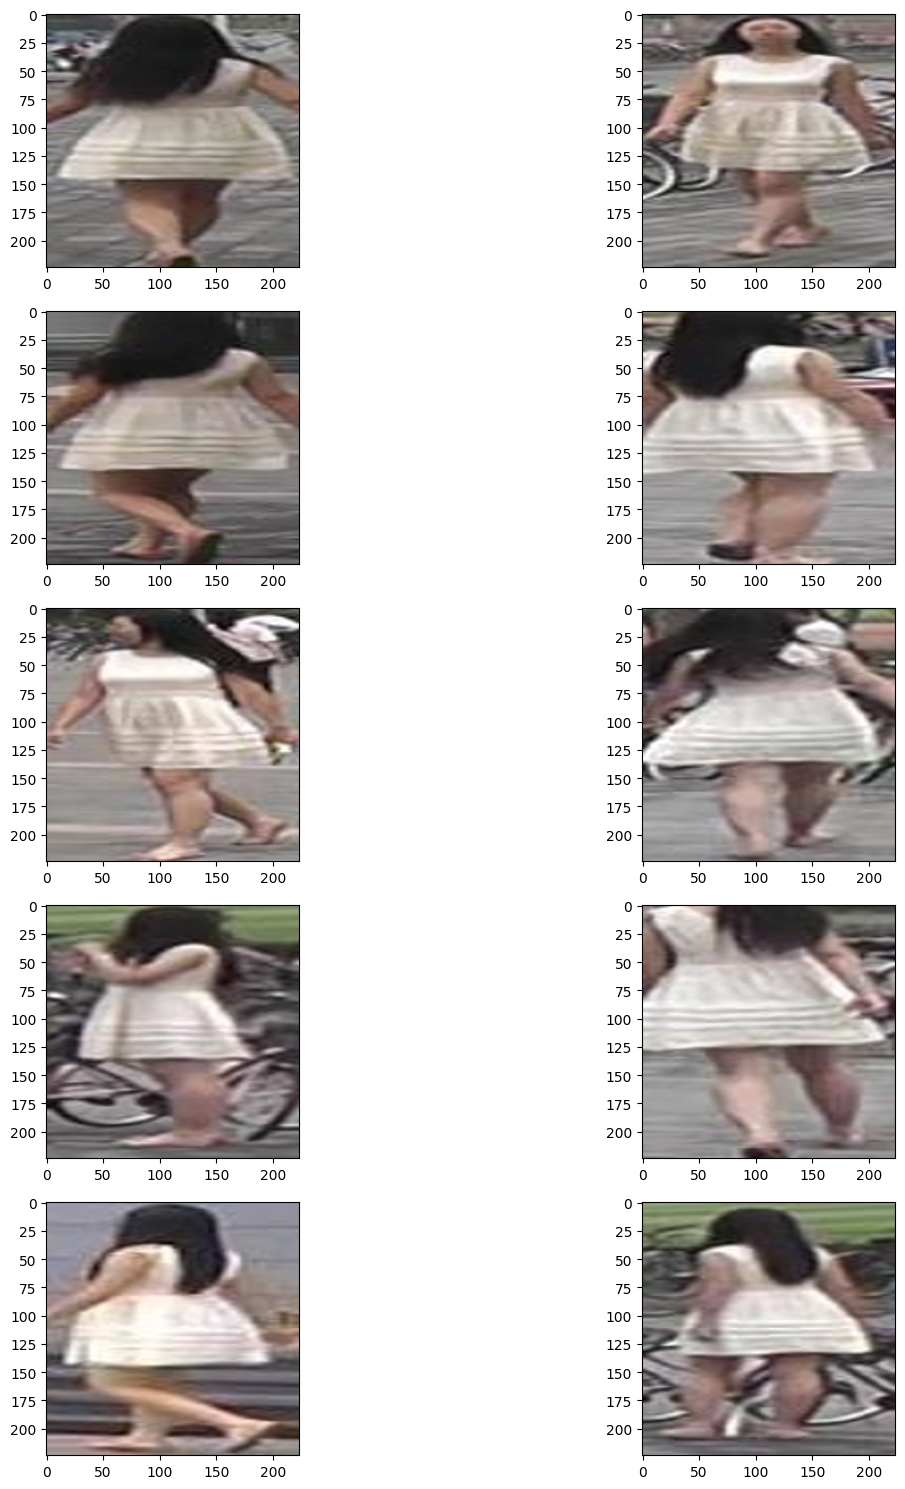

In [65]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each image in the respective subplot
for i, ax in enumerate(axes):
    images = image_datasets['gallery'][res_images[0][i]][0]
    images = images.numpy().transpose((1, 2, 0))
    images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    images = np.clip(images, 0, 1)
    ax.imshow(images)
# Adjust layout for clean appearance
plt.tight_layout()
plt.show()


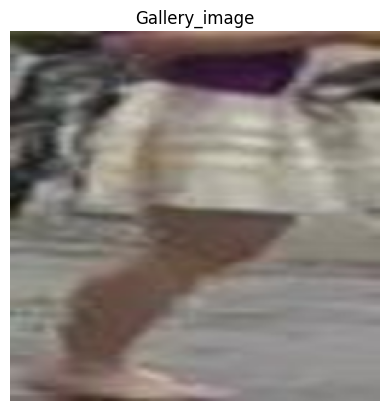

In [55]:
images = image_datasets['gallery'][530][0]
images = images.numpy().transpose((1, 2, 0))
images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
images = np.clip(images, 0, 1)
plt.imshow(images)
title = str(image_datasets['gallery'][6617][1])
plt.title(f'Gallery_image')
#
plt.axis('off')
plt.show()